In [1]:
from astropy.io import fits
from scipy.interpolate import interp1d
import functools
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
# The functions interp_grid(), coadd_brz_cameras(), index_dichotomy() are copied from prospect package (https://github.com/desihub/prospect).
def interp_grid(xval, xarr, yarr):
    """Basic linear interpolation of [`xarr`, `yarr`] on point `xval`.

    Translated from js/interp_grid.js.

    Parameters
    ----------
    xval : :class:`xval`
        Interpolate y-value at this point.
    xarr, yarr : array-like
        X, Y data.

    Returns
    -------
    :class:`float`
        The y-value corresponding to `xval`.
    """
    index = index_dichotomy(xval, xarr)
    a = (yarr[index+1] - yarr[index])/(xarr[index+1] - xarr[index])
    b = yarr[index]-a*xarr[index]
    yval = a*xval+b
    return yval

def index_dichotomy(point, grid):
    """Find nearest index in `grid`, left from `point`; use dichotomy method.

    Translated from js/interp_grid.js.

    Parameters
    ----------
    point : :class:`float`
        Value to find in `grid`.
    grid : array-like
        Values to search.

    Returns
    -------
    :class:`int`
        Nearest index.
    """
    if point < grid[0]:
        return 0
    if point > grid[-1]:
        return len(grid) - 2
    i_left = 0
    i_center = 0
    i_right = len(grid) - 1
    while i_right - i_left != 1:
        i_center = i_left + np.floor((i_right - i_left)/2)
        i_center = int(i_center)
        if point >= grid[i_center]:
            i_left = i_center
        else:
            i_right = i_center
    return i_left

def coadd_brz_cameras(wave_in, flux_in, noise_in, mask_in) :
    """Camera-coadd *brz* spectra.

    Translated from js/coadd_brz_cameras.js.

    Parameters
    ----------
    wave_in : array-like
        Set of three wavelength arrays corresponding to *brz*.
    flux_in : array-like
        Set of three flux arrays corresponding to *brz*.
    noise_in : array-like
        Noise arrays for weighting.

    Returns
    -------
    :func:`tuple`
        The coadded wavelength solution, flux and noise.

    Notes
    -----
    * Need to handle case of no noise.
    """

    # Find b,r,z ordering in input arrays
    wave_start = [wave_in[0][0], wave_in[1][0], wave_in[2][0]]
    i_b = wave_start.index(np.amin(wave_start))
    i_z = wave_start.index(np.amax(wave_start))
    i_r = 1
    for i in [0,1,2] :
        if ( (i_b != i) and (i_z != i) ) : i_r = i

    wave_out = []
    flux_out = []
    noise_out = []
    mask_out = []
    margin = 20
    for i in range(len(wave_in[i_b])) : # b
        if (wave_in[i_b][i] < wave_in[i_b][-1] - margin) :
            wave_out.append(wave_in[i_b][i])
            flux_out.append(flux_in[i_b][i])
            noise_out.append(noise_in[i_b][i])
            mask_out.append(mask_in[i_b][i])
    the_lim = wave_out[-1]
    for i in range(len(wave_in[i_r])) : # r
        if ( (wave_in[i_r][i] < wave_in[i_r][-1] - margin) and (wave_in[i_r][i] > the_lim)) :
            wave_out.append(wave_in[i_r][i])
            flux_out.append(flux_in[i_r][i])
            noise_out.append(noise_in[i_r][i])
            mask_out.append(mask_in[i_r][i])
    the_lim = wave_out[-1]
    for i in range(len(wave_in[i_z])) : # z
        if (wave_in[i_z][i] > the_lim) :
            wave_out.append(wave_in[i_z][i])
            flux_out.append(flux_in[i_z][i])
            noise_out.append(noise_in[i_z][i])
            mask_out.append(mask_in[i_z][i])
    for i in range(len(wave_out)) : # combine in overlapping regions
        b1 = -1
        b2 = -1
        if ( (wave_out[i] > wave_in[i_r][0]) and (wave_out[i] < wave_in[i_b][-1]) ) : # br
            b1 = 0
            b2 = 1
        if ( (wave_out[i] > wave_in[i_z][0]) and (wave_out[i] < wave_in[i_r][-1]) ) : # rz
            b1 = 1
            b2 = 2
        if (b1 != -1) :
            phi1 = interp_grid(wave_out[i], wave_in[b1], flux_in[b1])
            noise1 = interp_grid(wave_out[i], wave_in[b1], noise_in[b1])
            phi2 = interp_grid(wave_out[i], wave_in[b2], flux_in[b2])
            noise2 = interp_grid(wave_out[i], wave_in[b2], noise_in[b2])
            mask1 = interp_grid(wave_out[i], wave_in[b1], mask_in[b1])
            mask2 = interp_grid(wave_out[i], wave_in[b2], mask_in[b2])
            if mask1+mask2:
                mask_out[i] = 1
            if ( noise1 > 0 and noise2 > 0 ) :
                iv1 = 1/(noise1*noise1)
                iv2 = 1/(noise2*noise2)
                iv = iv1+iv2
                noise_out[i] = 1/np.sqrt(iv)
                flux_out[i] = (iv1*phi1+iv2*phi2)/iv
    return (np.asarray(wave_out), np.asarray(flux_out), np.asarray(noise_out), np.asarray(mask_out))

# The rebin() function is contributed by Ben Wang and modified by Zihao Li.
def rebin(wavelength,flux,error,mask,dlnlambda):
    """
    Resample and rebin the input spectra to a constant dlambda/lambda dispersion.
    Parameters
    ----------
    wavelength:
    flux:
    error:
    mask:
    dlnlambda: 
    Returns
    -------
    :func:`tuple`
        The rebinned wavelength solution, flux and noise.

    """
    c = 2.9979246e8
    # mask out bad pixels
    mask_idx = mask == 0
    wavelength = wavelength[mask_idx]
    flux = flux[mask_idx]
    error = error[mask_idx]


    max_wavelength = wavelength[-1]
    min_wavelength = wavelength[0]
    # max_wavelength = 9824.
    # min_wavelength = 3600.
    # Calculate how many pixels are needed for Rebinning in this spectra
    pixels_number = int(np.round(np.log(max_wavelength/min_wavelength)/dlnlambda))+1 #how many pixels in this spectra
    
    # Rebined wavelength
    new_wavelength = wavelength[0]*np.exp(dlnlambda*np.arange(pixels_number))
    
    # Endpoints of original pixels
    npix = len(wavelength)
    wvh = (wavelength + np.roll(wavelength, -1)) / 2.
    wvh[npix - 1] = wavelength[npix - 1] + \
                    (wavelength[npix - 1] - wavelength[npix - 2]) / 2.
    dwv = wvh - np.roll(wvh, 1)
    dwv[0] = 2 * (wvh[0] - wavelength[0])
    med_dwv = np.median(dwv)
    
    # Cumulative Sum
    cumsum = np.cumsum(flux * dwv)
    cumvar = np.cumsum(error * dwv, dtype=np.float64)
    
    # Interpolate
    fcum = interp1d(wvh, cumsum,bounds_error=False)
    fvar = interp1d(wvh, cumvar,bounds_error=False)
    
    # Endpoints of new pixels
    nnew = len(new_wavelength)
    nwvh = (new_wavelength + np.roll(new_wavelength, -1)) / 2.
    nwvh[nnew - 1] = new_wavelength[nnew - 1] + \
                     (new_wavelength[nnew - 1] - new_wavelength[nnew - 2]) / 2.
    
    # Pad starting point
    bwv = np.zeros(nnew + 1)
    bwv[0] = new_wavelength[0] - (new_wavelength[1] - new_wavelength[0]) / 2.
    bwv[1:] = nwvh
    
    # Evaluate
    newcum = fcum(bwv)
    newvar = fvar(bwv)
    # Rebinned flux, var
    new_fx = (np.roll(newcum, -1) - newcum)[:-1]
    new_var = (np.roll(newvar, -1) - newvar)[:-1]
    # Normalize (preserve counts and flambda)
    new_dwv = bwv - np.roll(bwv, 1)
    new_fx = new_fx / new_dwv[1:]
    # Preserve S/N (crudely)
    med_newdwv = np.median(new_dwv)
    new_var = new_var / (med_newdwv/med_dwv) / new_dwv[1:]
    
    return new_wavelength, new_fx, new_var

In [3]:
import os

In [4]:
def load_spectra(info_list):
        
    
    targ_id,release,survey,program,pix = info_list
    path = '/global/cfs/cdirs/desi/spectro/redux/%s/healpix/%s/%s'%(release,survey,program)
    healpix_loc = path+'/'+str(pix)[0:-2]+'/'+str(pix)
    spectra = healpix_loc+'/coadd-%s-%s-%s.fits'%(survey,program,pix)
    
    cat_path = '/global/cfs/cdirs/desi/spectro/redux/guadalupe/zcatalog'
    cat_name = 'zpix-%s-%s.fits'%(survey,program)
    cat_path = os.path.join(cat_path,cat_name)
    zcat = Table.read(cat_path,hdu=1)
    zcat.add_index('TARGETID')
    z = zcat.loc[targ_id]['Z']
    with fits.open(spectra) as spec:
        ids = spec['FIBERMAP'].data['TARGETID']
        targ_idx = targ_id == ids
        wave_b = spec['B_WAVELENGTH'].data.copy()
        wave_r = spec['R_WAVELENGTH'].data.copy()
        wave_z = spec['Z_WAVELENGTH'].data.copy()
        wave_in = [wave_b,wave_r,wave_z]
        
        flux_b = spec['B_FLUX'].data[targ_idx,:][0].copy()
        flux_r = spec['R_FLUX'].data[targ_idx,:][0].copy()
        flux_z = spec['Z_FLUX'].data[targ_idx,:][0].copy()
        flux_in = [flux_b,flux_r,flux_z]
        
        ivar_b = spec['B_IVAR'].data[targ_idx,:][0].copy()
        ivar_r = spec['R_IVAR'].data[targ_idx,:][0].copy()
        ivar_z = spec['Z_IVAR'].data[targ_idx,:][0].copy()
        noise_in = [1/ivar_b**0.5,1/ivar_r**0.5,1/ivar_z**0.5]
        
        mask_b = spec['B_MASK'].data[targ_idx,:][0]
        mask_r = spec['R_MASK'].data[targ_idx,:][0]
        mask_z = spec['Z_MASK'].data[targ_idx,:][0]
        mask_in = [mask_b,mask_r,mask_z]
        
        wave,flux,noise,mask = coadd_brz_cameras(wave_in, flux_in, noise_in,mask_in)

    return wave,flux,noise,mask,z

In [5]:
def which_range(z):
    """
        param name: name of qso fits file
        return: q_wave:wavelength at qso rest frame
        flux;inver;mask;wavelength;w_low,w_high for normalization;range name for nmf;redshifit of qso
    """
    if z<0.6:
        wavelength = [2300,8000]
        # wavelength=[2250,9824]
        wave_low=4150
        wave_high=4250
        range_name=1
    elif z<1.0:
        wavelength = [1300,6000]
        # wavelength = [1200,6140]

        wave_low=3020
        wave_high=3100
        range_name=2
    elif z<2.5:
        wavelength = [1100,4800]
        # wavelength=[1028,4912]
        wave_low=2150
        wave_high=2250
        range_name=3
    elif z<5.9:
        wavelength = [750,2700]
        # wavelength=[530,2807]
        wave_low=1420
        wave_high=1500
        range_name=4
    else:
        range_name=0
        return 0
    return wavelength,wave_low,wave_high,range_name

def normalize_initial(flux, invar, wave, z):
    """
        param flux;inver;mask;wavelength;w_low,w_high for normalization range;
        
        return:normalized flux,inverse vairiance, mask map and wavelength
        
    """
    nan_idx = np.isnan(flux)
    flux[nan_idx] = 0
    invar[nan_idx] = 0
    wavelength, wave_low, wave_high,rangename = which_range(z)
    del_wave = 0.8/5600/np.log(10)  # q0
    wave_ma = np.arange(np.log10(500), np.log10(10000), del_wave)  # q1
    dens_fix_ma = (10 ** (wave_ma + (del_wave / 2)) - 10 ** (wave_ma - (del_wave / 2)))
    logwave = np.log10(wave)
    dens_fix = (10 ** (logwave + (del_wave / 2)) - 10 ** (logwave - (del_wave / 2)))
    rest_wave = wave / (1 + z)

    flux_norm = flux[(rest_wave > wave_low) & (rest_wave < wave_high)]#newly update
    norm = np.mean(flux_norm)
    flux = flux / norm
    invar = invar * (norm ** 2)
    corflux = flux * dens_fix
    corivar = invar / (dens_fix ** 2)
    corwave = np.log10(rest_wave)
    base_shift = np.modf((corwave[0] - wave_ma[0]) / del_wave)  # q3
    s_shift = base_shift[1]
    fmodL = base_shift[0]
    fmodR = 1 - fmodL
    beta = ((fmodL * np.concatenate(([0], corflux))) + (fmodR * np.concatenate((corflux, [0]))))
    alpha = ((fmodL * np.concatenate(([0], corivar))) + (fmodR * np.concatenate((corivar, [0]))))
    endfix = np.int(wave_ma.shape[0] - np.int(s_shift) - beta.shape[0])
    mf = np.concatenate((np.zeros(np.int(s_shift)), beta, np.zeros(endfix)))
    mi = np.concatenate((np.zeros(np.int(s_shift)), alpha, np.zeros(endfix)))
    mf = mf / dens_fix_ma
    mi = mi * (dens_fix_ma ** 2)
    loc_cut = np.where((10 ** wave_ma > wavelength[0]) & (10 ** wave_ma < wavelength[1]))
    flux_new, invar_new, wave_ma = np.array(mf[loc_cut]), np.array(mi[loc_cut]), wave_ma[loc_cut]
    return flux_new, invar_new, wave_ma,rangename


def fitting(para, Wmatrix, initial, invar):
    """
        fit large scale fluctuation with pcs.
        params:
        para: weight of each pc
        Wmatrix: pcs
        initial: input flux
        invar: inverse variance, as weighing
        return: fitting err

    """
    out0 = np.zeros(np.shape(Wmatrix[0]), dtype=float)
    for i in range(len(para)):
        out0 += para[i] * Wmatrix[i]
    resi = np.sqrt(sum(((out0 - initial) ** 2 * invar)))
    return resi

def get_result(para, Wmatrix):
    out0 = np.zeros(np.shape(Wmatrix[0]), dtype=float)
    for i in range(len(para)):
        out0 += para[i] * Wmatrix[i]
    return out0


def read_file(qso_idx):

    """
    read file and normalize them
    """

    qso_idx = qso_idx
    qso_cat_i = qso_cat['__astropy_table__'][qso_idx]
    q_wave, flux, invar, mask, z_qso = qso_cat_i[5],qso_cat_i[6],1/qso_cat_i[7]**2,qso_cat_i[8],qso_cat_i[-3]

    wavelength, wave_low, wave_high, rangename = which_range(z_qso)

    flux_new, invar_new, mask_new, wave_ma = normalize_initial(flux, invar, mask, q_wave, z_qso)
    flux = flux_new
    invar = invar_new
    wave = wave_ma
    mask = mask_new
    z_qso = z_qso
    return flux,invar,wave,rangename,mask,z_qso

def continuum_fitting(flux_input,invar_input,wave_input,z_qso):
    
    
    flux,invar,wave,rangename = normalize_initial(flux_input,invar_input,wave_input,z_qso)

    para1 = np.ones(len(Ws[0]), dtype=float)

    corwave_rest = 10**wave*(1 + z_qso)
    if rangename == 1:
        Wmatrix = Ws[0]
    if rangename == 2:
        Wmatrix = Ws[1]
    if rangename == 3:
        Wmatrix = Ws[2]
    if rangename == 4:
        Wmatrix = Ws[3]
    # nmf fitting
    fitting1 = functools.partial(fitting, Wmatrix=Wmatrix, initial=flux, invar=invar)
    result = minimize(fitting1, x0=para1, method='SLSQP')
    nmfcontinuum = get_result(result['x'], Wmatrix)
    # median filter
    temp = flux / nmfcontinuum
    output_iter = np.ones(np.shape(temp), dtype=float)
    size1 = int(141)
    size2 = int(71)
    temp_temp = temp.copy()
    # can edit it to iteratively fitting, but seems 3 times is enough
    sigmas = [1.5, 1.5, 2.5]
    for j in range(3):
        output_tot = np.zeros(np.shape(temp), dtype=float)
        output_tot1 = np.zeros(np.shape(temp), dtype=float)
        clipmask = sigma_clip(temp_temp, sigma=sigmas[j]).mask
        locs = np.where(clipmask == False)[0]
        if len(locs) == 0:
            continue
        for ii in range(min(locs) + 10, max(locs) - 10):
            minx, maxx = max([ii - int(size1 / 2), 0]), min([ii + int(size1 / 2) + 1, len(temp)])
            zoom_spec = temp_temp[int(minx):int(maxx)]
            zoom_mask = clipmask[int(minx):int(maxx)]
            output_tot[ii] = np.median(zoom_spec[zoom_mask == False])
        temp_temp1 = temp_temp / output_tot
        clipmask = sigma_clip(temp_temp1, sigma=sigmas[j]).mask
        for ii in range(min(locs) + 10, max(locs) - 10):
            minx, maxx = max([ii - int(size2 / 2), 0]), min([ii + int(size2 / 2), len(temp)])
            zoom_spec = temp_temp1[int(minx):int(maxx)]
            zoom_mask = clipmask[int(minx):int(maxx)]
            output_tot1[ii] = np.median(zoom_spec[zoom_mask == False])
        temp_temp = temp_temp1 / (output_tot1)
        output_iter = output_iter * (output_tot * output_tot1)
    medianfilter = output_iter
    continuum_final = medianfilter*nmfcontinuum
    temps = flux / (continuum_final)
    temp_inva = invar * (continuum_final) ** 2

    normalized_flux = temps
    normalized_flux = np.where(normalized_flux==np.inf,np.nan,normalized_flux)
    normalized_flux = np.where(normalized_flux==-np.inf,np.nan,normalized_flux)
    normalized_inv = temp_inva
    wave_rest = corwave_rest
    
    return wave_rest,normalized_flux,normalized_inv,wave,flux,invar,continuum_final,




Wspath = 'pcs_desi/'
Wa = np.load(Wspath + 'W_1.npy').T
Wb = np.load(Wspath + 'W_2.npy').T
Wc = np.load(Wspath + 'W_3.npy').T
Wd = np.load(Wspath + 'W_4.npy').T
Ws = [Wa,Wb,Wc,Wd]

In [6]:
info_list = [39637324216140592,'guadalupe','main','dark',9738]

In [7]:
targ_id,release,survey,program,pix = info_list
path = '/global/cfs/cdirs/desi/spectro/redux/%s/healpix/%s/%s'%(release,survey,program)
healpix_loc = path+'/'+str(pix)[0:-2]+'/'+str(pix)
spectra = healpix_loc+'/coadd-%s-%s-%s.fits'%(survey,program,pix)

In [8]:
wave,flux,noise,mask,z = load_spectra(info_list)
wave, flux, noise = rebin(wave, flux, noise, mask, 0.8/5600)

invar = 1/noise**2

In [9]:
wave_cont,normalized_flux,normalized_inv,wave_initial,flux_initial,invar_initial,continuum_final = continuum_fitting(flux,invar,wave,z)

<ipython-input-5-bd347e0e787e>:162: RuntimeWarning: divide by zero encountered in true_divide
  temp_temp1 = temp_temp / output_tot
<ipython-input-5-bd347e0e787e>:162: RuntimeWarning: invalid value encountered in true_divide
  temp_temp1 = temp_temp / output_tot
<ipython-input-5-bd347e0e787e>:162: RuntimeWarning: divide by zero encountered in true_divide
  temp_temp1 = temp_temp / output_tot
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-5-bd347e0e787e>:162: RuntimeWarning: divide by zero encountered in true_divide
  temp_temp1 = temp_temp / output_tot
<ipython-input-5-bd347e0e787e>:1

<ipython-input-10-fad86c54d53c>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(10**wave_initial*(1+z),1/invar_initial**0.5,label='Error')


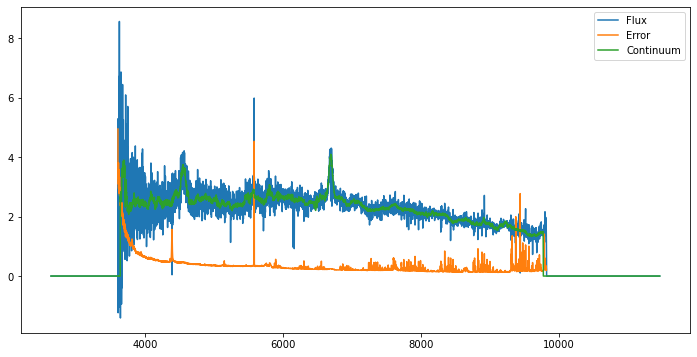

In [10]:
plt.figure(figsize=(12,6))
plt.plot(10**wave_initial*(1+z),flux_initial,label='Flux')
plt.plot(10**wave_initial*(1+z),1/invar_initial**0.5,label='Error')
plt.plot(wave_cont,continuum_final,label='Continuum')
plt.legend()

<ipython-input-11-a06810547db5>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(wave_cont,1/normalized_inv**0.5,label='Error')


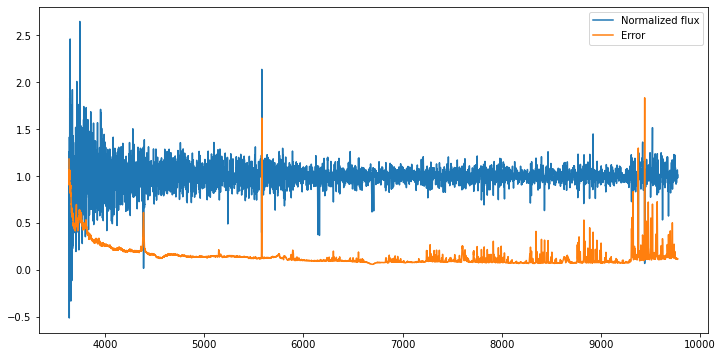

In [11]:
plt.figure(figsize=(12,6))
plt.plot(wave_cont,normalized_flux,label='Normalized flux')
plt.plot(wave_cont,1/normalized_inv**0.5,label='Error')
plt.legend()